In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 
import json

git_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(git_dir, 'astrobot'),
        os.path.join(git_dir, 'deeprad'),
        os.path.join(git_dir, 'pincam')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *
from astrobot.geomdataframe import GeomDataFrame 
from astrobot.r import R
from astrobot import bem_util, geom_util, mtx_util
#from astrobot.polymesh import PolyMesh

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
#import itertools

import ladybug_geometry.geometry3d as geom3
import ladybug_geometry.geometry2d as geom2
from ladybug_geometry_polyskel import polyskel

# Simulation
from honeybee_energy.simulation.output import SimulationOutput
from honeybee_energy.simulation.parameter import SimulationParameter

import honeybee.dictutil as hb_dict_util
from ladybug.epw import EPW

# For camera
from shapely.geometry import Polygon
from pincam import Pincam

from ladybug.sql import SQLiteResult
from honeybee_energy.result import match


In [12]:
from astrobot.facade_traintest_data import * 
import astrobot.facade_traintest_data as ftd 

num = False

In [41]:

RDD_SRF_DICT = {
        'srf_win_heat_loss': 'Surface Window Heat Loss Energy',
        'srf_win_heat_gain': 'Surface Heat Window Gain Energy',
        'srf_heat_transfer': 'Surface Average Face Conduction Heat Transfer Energy',
        'srf_win_sol': 'Surface Window Transmitted Solar Radiation Energy',
        'srf_sol_inc': 'Surface Outside Face Incident Solar Radiation Rate per Area',
        'srf_in_sol': 'Surface Inside Face Solar Radiation Heat Gain Rate',
        'srf_cos': 'Surface Outside Face Beam Solar Incident Angle Cosine Value',
        'srf_in_infra': 'Surface Inside Face Net Surface Thermal Radiation Heat Gain Rate'
        }

rdd_srf_var = RDD_SRF_DICT['srf_in_infra']

# ---------------------------------------------------------------------------------
# Get al HB models and simfpaths
# ---------------------------------------------------------------------------------

deeprad_hbjsons_dir = \
    os.path.join(os.getcwd(), '../../..', 'deeprad/data/hbjsons2/')
deeprad_hbjsons_dir = os.path.abspath(deeprad_hbjsons_dir)
traintest_dir = os.path.join(deeprad_hbjsons_dir, '..', 'traintest2')

_model_fpaths = sorted(os.listdir(deeprad_hbjsons_dir),
    key=lambda s: int(s.split('_')[0]))
_model_fpaths = [os.path.join(deeprad_hbjsons_dir, mf) for mf in _model_fpaths]

_model_fpaths = _model_fpaths[900:]
#if num:
_model_fpaths = _model_fpaths[1000:]

models, model_sims = flattened_bems(_model_fpaths)
model_num = len(models)

# ---------------------------------------------------------------------------------
# Init r.mod
# ---------------------------------------------------------------------------------

# make R
mod_df = GeomDataFrame(
    {'model_id': [m.identifier for m in models],
        'model': models,
        'sim_fpath': model_sims})

r = R(mod_df)
model_num = len(r.mod)
r.mod['null'] = np.ones(model_num)

print('# of models', model_num)

# ---------------------------------------------------------------------------------
# Init r.srf
# ---------------------------------------------------------------------------------

# Add srfs
faces, face_mod_idxs = [], []
for i, model in enumerate(mod_df['model']):
    faces.extend(model.faces)
    face_mod_idxs.extend([i] * len(model.faces))

# TODO: Mtx > mtx_util, Mtx_geom > mtx_geom_util, mtx_geom, move mtx_utli to Mtx?
r.srf = GeomDataFrame({'mod_idx': face_mod_idxs, 'srf_geom': faces})
r.srf['type'] = [srf.type.name for srf in r.srf['srf_geom']]
r.srf['bc'] = [srf.boundary_condition.name for srf in r.srf['srf_geom']]
srf_num = len(faces)

# of models 0


In [14]:
# ---------------------------------------------------------------------------------
# Add sim data to r.srf
# ---------------------------------------------------------------------------------

# Extract srf sim data
r.srf['srf_heat_transfer'] = np.empty(srf_num)
r.srf['srf_heat_transfer'] = np.NaN

# Update surfaces for each model
for i, sim_fpath in enumerate(r.mod['sim_fpath']):

    # Get exterior faces
    srf_mod_idx = r.srf.query('mod_idx == {}'.format(i)).index
    if not os.path.isfile(sim_fpath):
        continue

    sql = SQLiteResult(sim_fpath)
    srf_sim_data = sql.data_collections_by_output_name(rdd_srf_var)

    r_srf_geom_arr = r.srf.loc[srf_mod_idx, 'srf_geom']
    _fil_mod_idx, _fil_data = reorder_to_srf_geom_arr(r_srf_geom_arr, srf_mod_idx, srf_sim_data)
    r.srf.loc[_fil_mod_idx, 'srf_heat_transfer'] = _fil_data


In [15]:
def _project(P, pmtx, ortho=True, res=2):
    """Wrapper for pincam projection."""
    xformed_ptmtx, depths = Pincam.project(P, pmtx, ortho=ortho)
    #depths, db = cam.depth_buffer(ptmtx, _depths, res=res)
    xformed_ptmtx = [xformed_ptmtx[d] for d in depths]
    return [Pincam.to_poly_sh(poly_np) for poly_np in xformed_ptmtx], depths

def _cam_cmap(poly_sh_arr, cmap_arr, a, **kwargs):
    """Cmap from values."""
    # normalize color
    cmap = 'RdYlBu_r'
    srf_df = GeomDataFrame({'geometry': poly_sh_arr, 'var': cmap_arr})
    a = srf_df.plot(column='var', edgecolor='black',
                    cmap=cmap, legend=False, ax=a, **kwargs)
    a.axis('equal'); a.axis('off')
    return a

# ---------------------------------------------------------------------------------
# Plot facade
# ---------------------------------------------------------------------------------
# Define constant camera properteis
FOCAL_LEN = 45.0
PITCH = deg2rad(15)  # Z
CAM_POSN = np.array([0, -35, 2.5])  # camera placed at 2nd floor
angle_iter = 45
CAM_ANGLES = np.arange(0, 180 + angle_iter, angle_iter)
PLT_NUM, PLT_HT = len(CAM_ANGLES), 4
ORTHO = True

min: 0.0, max: 94.61


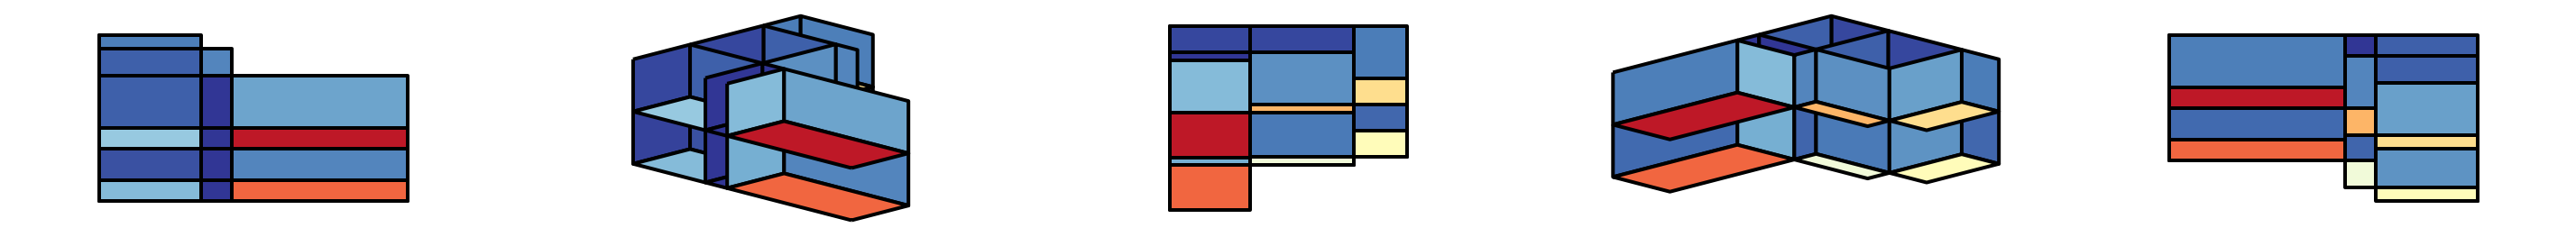

In [16]:
mod_idx = 14
sim_fpath = r.mod.loc[mod_idx, 'sim_fpath']
# ---------------------------------------------------------------------------------
# Out
# ---------------------------------------------------------------------------------
f, a = plt.subplots(
    1, PLT_NUM, figsize=(2 * PLT_HT * PLT_NUM, PLT_HT), sharey=True)
plt.setp(a, yticks=np.arange(10, -10, 2))
f.tight_layout()

for i, cam_angle in enumerate(CAM_ANGLES):

    # Filter polys in view     
    cam = Pincam(CAM_POSN, deg2rad(cam_angle), PITCH, FOCAL_LEN)
    _mask = r.srf.query('mod_idx == {}'.format(mod_idx)).index
    _poly_np_arr = [to_poly_np(poly_lb, True) for poly_lb in r.srf.loc[_mask, 'srf_geom']]
    mask_bool = ftd.poly_in_cam_view(cam.P, _poly_np_arr, in_view=True)
    
    # Filter by boolean mask  
    poly_np_arr = [_poly_np for m, _poly_np in zip(mask_bool, _poly_np_arr) if m]
    mask = [_m for m, _m in zip(mask_bool, _mask) if m]

    # Do projection
    poly_sh_arr, depths = _project(cam.P, poly_np_arr, ortho=ORTHO, res=1)
    srf_heat_arr = r.srf.loc[mask, 'srf_heat_transfer'].values
    srf_heat_arr = np.array([srf_heat_arr[d] for d in depths])
    
    if not i:
        #print(r.mod.loc[mod_idx, 'sim_fpath'])
        minv, maxv = srf_heat_arr[~np.isnan(srf_heat_arr)].min(), srf_heat_arr[~np.isnan(srf_heat_arr)].max()
        print('min: {}, max: {}'.format(np.round(minv, 2), np.round(maxv, 2)))
        
    srf_heat_arr = srf_heat_arr
    srf_heat_arr[np.where(np.isnan(srf_heat_arr))] = 0

    #color_arr = 'lightblue' #[ for ii in srf_df['srf_heat_transfer']]
    #_cam_color(poly_sh_arr, color_arr, a[i], linewidth=4)
    vmin, vmax = 0, 100
    a[i] = _cam_cmap(poly_sh_arr, srf_heat_arr, a[i], linewidth=4, vmin=vmin, vmax=vmax)
    #plt.savefig('test.jpg')

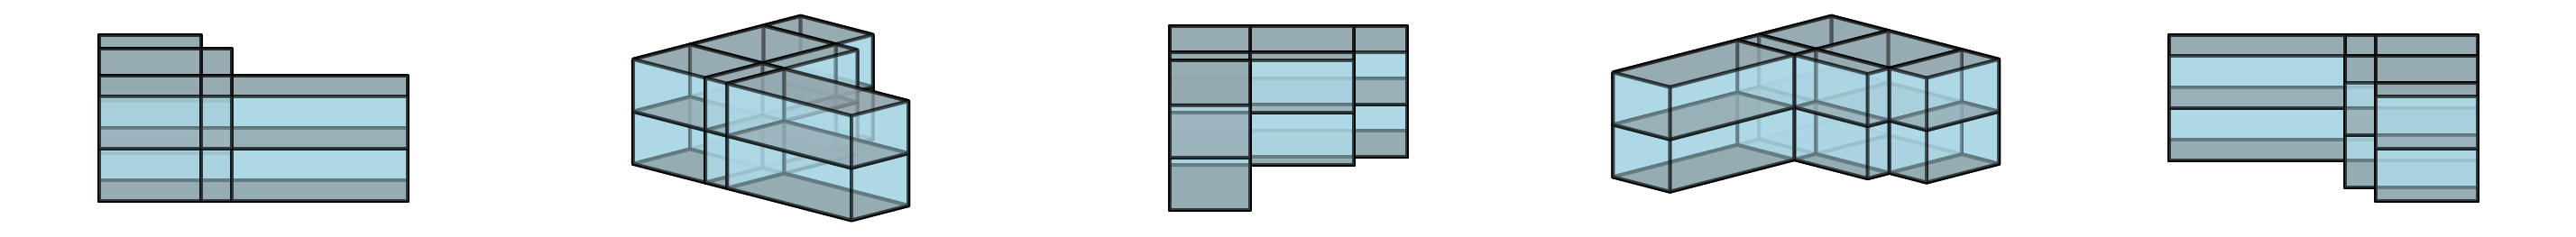

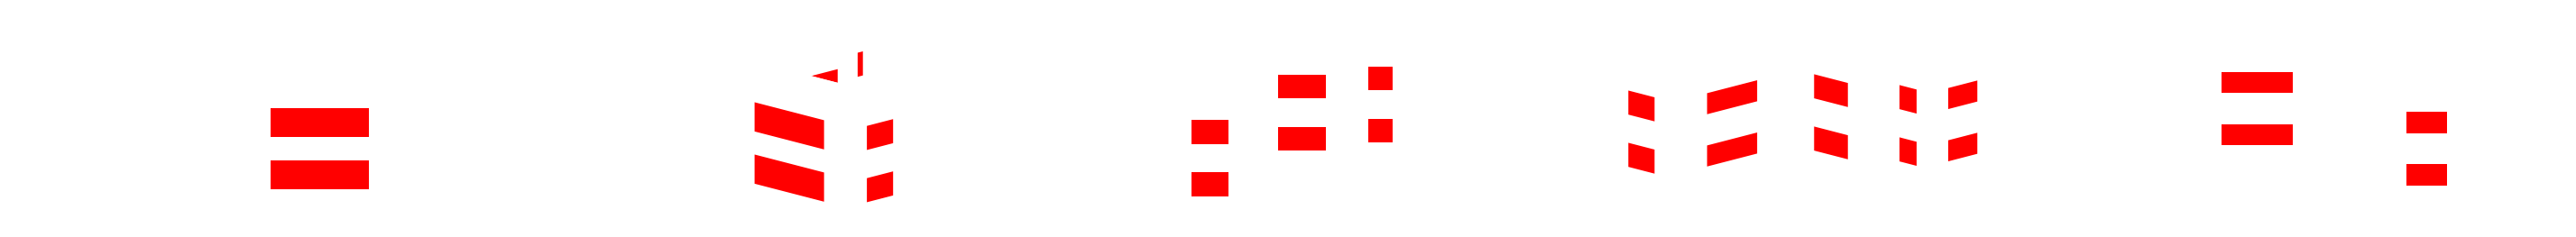

In [39]:
from astrobot import facade_traintest_data as ftd 

srf_f, srf_a = plt.subplots(1, PLT_NUM, figsize=(2 * PLT_HT * PLT_NUM, PLT_HT), sharey=True)
plt.setp(srf_a, yticks=np.arange(10, -10, 2))
win_f, win_a = plt.subplots(1, PLT_NUM, figsize=(2 * PLT_HT * PLT_NUM, PLT_HT), sharey=True)
plt.setp(win_a, yticks=np.arange(10, -10, 2))
srf_f.tight_layout(); win_f.tight_layout()

for i, cam_angle in enumerate(CAM_ANGLES):
    # Get surfaces 
    mask = r.srf.query('mod_idx == {}'.format(mod_idx)).index
    srf_geoms = r.srf.loc[mask, 'srf_geom']
    _win_geoms = [srf_geom.apertures for srf_geom in srf_geoms]
    _win_geoms = [j for i in _win_geoms for j in i]
    win_geoms = [win_geom.duplicate().geometry.move(win_geom.normal.duplicate() * 0.001) 
                 for win_geom in _win_geoms]
    
    srf_np_arr = [to_poly_np(poly_lb, True) for poly_lb in srf_geoms]
    win_np_arr = [to_poly_np(poly_lb, True) for poly_lb in win_geoms]

    # Camera 
    cam = Pincam(CAM_POSN, deg2rad(cam_angle), PITCH, FOCAL_LEN)
    # filter srfs by in view 
    srf_np_arr = [to_poly_np(poly_sh) for poly_sh in r.srf.loc[mask, 'srf_geom']]
    mask_bool = ftd.poly_in_cam_view(cam.P, srf_np_arr, in_view=True)
    view_srf_np_arr = [srf_np for m, srf_np in zip(mask_bool, srf_np_arr) if m]
    view_mask = [_m for b, _m in zip(mask_bool, mask) if b]
    
    # Project 
    view_srf_sh_arr, view_srf_depths = _project(cam.P, view_srf_np_arr, ortho=ORTHO, res=1)
    win_sh_arr, win_depths = _project(cam.P, win_np_arr, ortho=ORTHO, res=1)
    srf_sh_arr, srf_depths = _project(cam.P, srf_np_arr, ortho=ORTHO, res=1)
    all_sh_arr, all_depths = _project(cam.P, srf_np_arr + win_np_arr, ortho=ORTHO, res=1)
    
    
    # label depths by type 
    win_start_idx = len(srf_np_arr)
    type_str = ['win' if d >= win_start_idx else 'srf' for d in all_depths]
    type_dict = dict(zip(all_depths, type_str))
    
    # colors for view srfs
    vbcs = r.srf.loc[view_mask, 'bc'].values
    vbcs = np.array([vbcs[d] for d in view_srf_depths])
    view_srf_color_arr = [0] * len(view_srf_sh_arr)
    for k, _vbc in enumerate(vbcs):
        view_srf_color_arr[k] = 'grey' if _vbc == 'Adiabatic' else 'lightblue'
    
    # colors for srfs
    abcs = r.srf.loc[mask, 'bc'].values
    abcs = np.array([abcs[d] for d in srf_depths])
    srf_color_arr = [0] * len(srf_sh_arr)
    for k, _abc in enumerate(abcs):
        srf_color_arr[k] = 'grey' if _abc == 'Adiabatic' else 'lightblue'
    
    # colors for wins
    bcs = r.srf.loc[mask, 'bc'].values
    bcs = np.array([bcs[d] for d in srf_depths])
    srf_i = 0
    all_color_arr = [0] * len(all_sh_arr)
    for k, (all_sh, all_depth) in enumerate(zip(all_sh_arr, all_depths)):
        if type_dict[all_depth] == 'win':
            all_color_arr[k] = 'red'
        else:
            all_color_arr[k] = 'white' if bcs[srf_i] == 'Adiabatic' else 'white'
            srf_i += 1
    
    # Ghost the building
    srf_a[i] = ftd._cam_color(view_srf_sh_arr, view_srf_color_arr, srf_a[i], linewidth=4)
    srf_a[i] = ftd._cam_color(srf_sh_arr, srf_color_arr, a=srf_a[i], linewidth=4, alpha=0.5)

    # second channel
    ftd._cam_color(all_sh_arr, all_color_arr, win_a[i], linewidth=0)
    del _win_geoms; del win_geoms



In [ ]:

ss = r.srf.loc[mask, 'srf_geom'].values[2]

print(fd(ss, 'ape'))

ss.apertures[0]


#fd(ss)
#ss.cardinal_direction()
#ss.center
